# Plotting Fisher predictions for $\Delta\alpha$ against numerical simulations

Import packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import arviz as az
from sympy.parsing import mathematica as M


%matplotlib inline
np.random.seed(1234)

az.style.use("arviz-darkgrid")

# Nice plotting options.

params = {'axes.labelsize': 14,
          'font.size': 14,
          'axes.linewidth': 1,
          'legend.fontsize': 11,
          'xtick.labelsize': 14,
          'xtick.top': True,
          'ytick.labelsize': 14,
          'ytick.right': True,
          'axes.grid' : True,
          'savefig.dpi' : 100,
          'lines.markersize' : 4,
          'axes.formatter.limits' : (-3,3)}

mpl.rcParams.update(params)

# LaTeX rendering.

from matplotlib import rc
rc('text', usetex=True)

We define some true parameters that we'll need.

In [2]:
"""
Parameters
"""

# Inputs to get the true ln M distribution.
# Notice that M runs from 10^4 to 10^7 in GTV.

alpha0_t = 0.00001 # Choose flat spectral profile.
M_min=10000. 
M_max=10000000.
logM_min = np.log(M_min)
logM_max = np.log(M_max)


N_obs = 60
N_samp_per_obs = 10

### Fisher predictions

For this exercise, we use the expression for $\Delta\alpha$ obtained retaining the first term in the integral only, when no selection effects are present.

In [3]:
from sympy.parsing import mathematica as M
Dalpha_simpified = M.mathematica('Sqrt[1/(Nobs*(alpha^(-2) - (Mmax^alpha*Mmin^alpha*(Log[Mmax] - Log[Mmin])^2)/(Mmax^alpha - Mmin^alpha)^2))]')

def Dalpha(Nobs,alpha,Mmin,Mmax):
    
    out = Dalpha_simpified.subs([('Nobs',Nobs),('alpha',alpha),('Mmax',Mmax),('Mmin',Mmin)]).evalf()
    
    return float(out)

print('Analytical expression for the variance on the spectral index:')
Dalpha_simpified

Analytical expression for the variance on the spectral index:


sqrt(1/(Nobs*(-Mmax**alpha*Mmin**alpha*(log(Mmax) - log(Mmin))**2/(Mmax**alpha - Mmin**alpha)**2 + alpha**(-2))))

We create a list of $\Delta\alpha$ as a function of $N_\text{obs}$

In [4]:
# List without selection effects.

Da_list =[]
for N in range(1,33 ):
    Da_list.append(Dalpha(N,alpha0_t,M_min,M_max))
    
# List with selection effects.

Da_list_sel =[]
for N_det in range(1,33):
    Da_list_sel.append(np.sqrt(106/(N_det*86.39531326294203)))

### MCMC analyses without selection effects

Generate a set of $N_{\rm obs}$ observations, and then split this in such a way to have repetitions of $M_{\rm obs}$ observations. 

In [5]:
import emcee
import seaborn as sns

In [6]:
def model(lnM,alpha):
    
    M = np.exp(lnM) # mass observations
    norm  = alpha/(M_max**alpha-M_min**alpha)
    
    return norm*M**(alpha-1)

In [7]:
sigma = 0.1
noise = np.random.normal(0,sigma,size = N_obs)

"""
Data draws before chunks.
"""
u = np.random.uniform(size=N_obs)
logM_t=alpha0_t**-1 * np.log((M_max**(alpha0_t)-M_min**(alpha0_t))*u+ M_min**(alpha0_t)*np.ones(N_obs))
d_i = noise + logM_t 

Function to get the MCMC widths without selection effects given some data.

In [8]:
# Limits of (flat) hyperpriors.

N_samps_likelihoods = 10
N_samps_selfunction = 10000

# Limits of (flat) hyperpriors.

hyperprior_min = -100.0
hyperprior_max = 100.0

# Iterations, ndims and walkers.

n_iter = 10000
ndim = 1; nwalkers = 4

burnin = 1500
pos_init0 = [alpha0_t]


In [9]:
from MCMC_PowerLaw   import * # Import utils to perform the MCMC analysis.


def data_chunks(d_i, M_obs):
    
    #Generate data
    #d_i = noise + logM_t 
    #Prepare chunks of data by dividing full length by M_obs
    chunked_data = [d_i[i:i + M_obs] for i in range(0, len(d_i), M_obs)]
    
    data_list = []
    for element in chunked_data:
        
        data=np.zeros((M_obs,N_samp_per_obs))
        for i in np.arange(M_obs):
            data[i,:]=np.random.normal(element[i],sigma,size=N_samp_per_obs)
            
    
        data_list.append(data)
    
    return data_list

def MCMC_width_nosel(data,M_obs):
    
    """
    Function that calculates the expected error from an MCMC run. 
    Takes as input the chunked data (for the argument of sampler) and the 
    number of observations in each chunked data.
    """
    
    p0 = pos_init0*(1+0.001* np.random.randn(nwalkers, ndim))

    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood_nosel,
                                args=[data,hyperprior_min,hyperprior_max,
                                      M_max, M_min, sigma, M_obs]
                               )
    run = sampler.run_mcmc(p0, n_iter, progress=False)
    chains = sampler.get_chain(discard=burnin, thin=1, flat=False)
    alpha_samples = chains[:,:,0].flatten()
    
    return np.sqrt(np.var(alpha_samples))


def MCMC_errorbars(data, M_obs):
    
    """
    Function to return a list of number of detections and MCMC widths to 
    take the standard deviation from. 
    
    These are inputs in the error bar plots.
    """
    widths_list = []
    
    for data in data_chunks(d_i, M_obs):
    
        width = MCMC_width_nosel(data,M_obs)
        widths_list.append(width)
        
    return [M_obs for i in range(len(widths_list))], widths_list

In [10]:
# MCMC runs: might take a few minutes.

MCMC_run_30 = MCMC_errorbars(d_i, 30)
MCMC_run_20 = MCMC_errorbars(d_i, 20)
MCMC_run_15 = MCMC_errorbars(d_i, 15)
MCMC_run_10 = MCMC_errorbars(d_i, 10)
MCMC_run_5  = MCMC_errorbars(d_i, 5)
MCMC_run_2  = MCMC_errorbars(d_i, 2)

### Final plot for paper

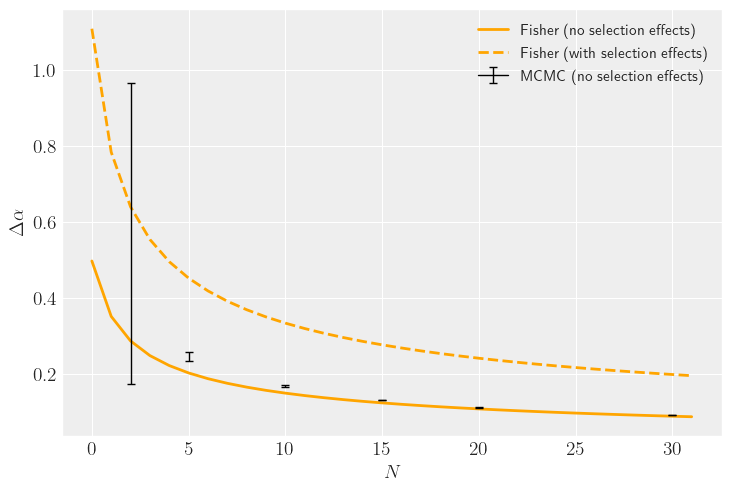

In [18]:
# Fisher predictions

plt.plot(Da_list,c='orange',lw=2, label='Fisher (no selection effects)')
plt.plot(Da_list_sel,c='orange', ls='--',lw=2, label='Fisher (with selection effects)')


# Plot error bars


plt.errorbar(30, np.mean(MCMC_run_30[1]), yerr=np.std(np.array(MCMC_run_30[1])), 
             c='black', lw=100,capsize=3)

plt.errorbar(20, np.mean(MCMC_run_20[1]), yerr=np.std(np.array(MCMC_run_20[1])), 
             c='black', lw=3,capsize=3)
   
plt.errorbar(15, np.mean(MCMC_run_15[1]), yerr=np.std(np.array(MCMC_run_15[1])), 
             c='black', lw=3,capsize=3)

plt.errorbar(10, np.mean(MCMC_run_10[1]), yerr=np.std(np.array(MCMC_run_10[1])), 
             c='black', lw=1,capsize=3, label='MCMC (no selection effects)')

plt.errorbar(5, np.mean(MCMC_run_5[1]), yerr=np.std(np.array(MCMC_run_5[1])), 
             c='black', lw=1,capsize=3)

plt.errorbar(2, np.mean(MCMC_run_2[1]), yerr=np.std(np.array(MCMC_run_2[1])), 
             c='black', lw=1,capsize=3)


plt.xlabel('$N$')
plt.ylabel('$\Delta\\alpha$')
plt.legend()